In [1]:
from header.Keras.Wavenet_model import Wavenet
from header.Keras.dataset import generate_data
from header.Keras.train_and_test import scheduler, train_val_plot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.random import uniform
import tensorflow as tf
tf.keras.backend.set_floatx('float64')

from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import time
import glob
import os

# Prepare data
1. input_shape = (batch_size, time_step, feature_num)

In [3]:
# Read data
lag = 44
gap = 22

label = 'label'
date_idx = 'tmp_index_ts_value_20200430_henry.tx_dt'
df = pd.read_csv('./csv_dataset/data_prepro_0814.csv').dropna(axis = 0).reset_index(drop = True)

# --------------Training-----------------
x_train, y_train, train_date = generate_data(df = df, label_idx = 'label',
                                             date_idx = date_idx, lag = lag, gap = gap,
                                             normalize_method = 'min-max',
                                             start = None, end = '2017-09-29')
print(x_train.shape, y_train.shape)
print('Train the model from {} to {}.\n'.format(train_date[0], train_date[-1]))


# ----------------Testing----------------
x_test, y_test, test_date = generate_data(df = df, label_idx = 'label',
                                          date_idx = date_idx, lag = lag, gap = gap,
                                          normalize_method = 'min-max',
                                          start = '2017-09-29', end = None)
print(x_test.shape, y_test.shape)
print('Test the model from {} to {}.'.format(test_date[0], test_date[-1]))

(3115, 44, 103) (3115, 1)
Train the model from 2005-10-21 to 2017-09-28.

(551, 44, 103) (551, 1)
Test the model from 2018-01-01 to 2020-02-25.


# Build model and training

In [4]:
model = Wavenet(time_step = 44, feature_num = 103, kernel_size = 5,
                num_blocks = 3, num_layers = 3, output_channel = 103, reg = 0)

optimizer = Adam(lr = 6e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)

metric = 'binary_accuracy'
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = metric)

# Some callbacks
Scheduler = LearningRateScheduler(scheduler)
Early_stopping = EarlyStopping(monitor = "val_" + metric, min_delta = 1e-4, patience = 30, 
                               verbose = 1, mode = "auto", baseline = None, 
                               restore_best_weights = False)

# make keras checkpoint directory
checkpoint_path = "./Keras_model_ckpt/best_model.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
if 'Keras_model_ckpt' not in glob.glob('*'):
    try:
        os.mkdir(path)
    except OSError:
        print ("Creation of the directory %s failed" % path)
    else:
        print ("Successfully created the directory %s " % path)

model_ckpt = ModelCheckpoint(filepath = checkpoint_path, monitor = "val_" + metric, verbose = 0, 
                             save_best_only = True, save_weights_only = True, 
                             mode = 'auto', save_freq = 'epoch')



In [5]:
start = time.time()
print('Start to train...')
history = model.fit(x = x_train, y = y_train, batch_size = 128, epochs = 40, 
             verbose = 1, callbacks = [Scheduler, model_ckpt], validation_split=0.2, 
             validation_data=None, shuffle=True, class_weight=None,
             sample_weight=None, initial_epoch=0, steps_per_epoch=None,
             validation_steps=None)
end = time.time()
print('End in {:.3f}s.'.format(end - start))

Start to train...
Epoch 1/40
20/20 [==============================] - 24s 1s/step - loss: 0.6778 - binary_accuracy: 0.5040 - val_loss: 0.6879 - val_binary_accuracy: 0.5698 - lr: 5.4290e-04
Epoch 2/40
20/20 [==============================] - 25s 1s/step - loss: 0.6470 - binary_accuracy: 0.5441 - val_loss: 0.6874 - val_binary_accuracy: 0.5152 - lr: 4.9124e-04
Epoch 3/40
20/20 [==============================] - 22s 1s/step - loss: 0.6228 - binary_accuracy: 0.5766 - val_loss: 0.6910 - val_binary_accuracy: 0.5201 - lr: 4.4449e-04
Epoch 4/40
20/20 [==============================] - 24s 1s/step - loss: 0.5945 - binary_accuracy: 0.6023 - val_loss: 0.6960 - val_binary_accuracy: 0.5297 - lr: 4.0219e-04
Epoch 5/40
20/20 [==============================] - 23s 1s/step - loss: 0.5840 - binary_accuracy: 0.6083 - val_loss: 0.7006 - val_binary_accuracy: 0.4767 - lr: 3.6392e-04
Epoch 6/40
20/20 [==============================] - 23s 1s/step - loss: 0.5606 - binary_accuracy: 0.6300 - val_loss: 0.7010 - v

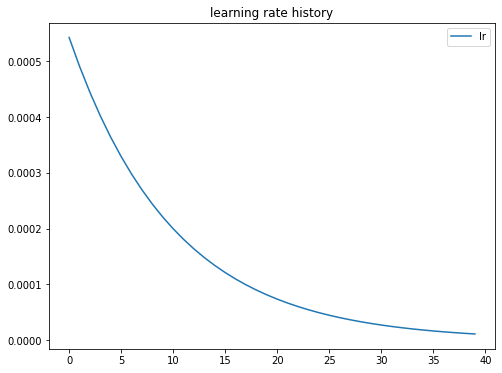

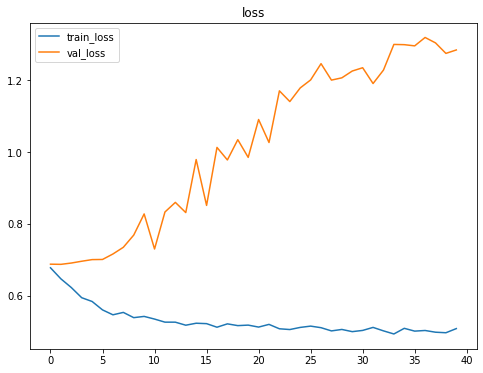

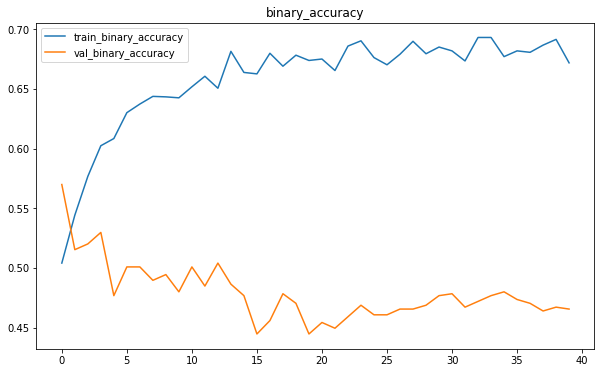

In [6]:
train_val_plot(history, metric)

# Evaluate model

In [7]:
# Load origin model
y_true = y_test.reshape(-1)
y_pred = np.round(model.predict(x_test).reshape(-1))

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.34      0.39       273
           1       0.49      0.62      0.55       278

    accuracy                           0.48       551
   macro avg       0.48      0.48      0.47       551
weighted avg       0.48      0.48      0.47       551



In [9]:
# Load best model
best_model = Wavenet(time_step = 44, feature_num = 103, kernel_size = 5,
                     num_blocks = 3, num_layers = 3, output_channel = 103, reg = 1e-2)
optimizer = Adam(lr = 6e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
metric = 'binary_accuracy'
best_model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = metric)
best_model.load_weights('./Keras_model_ckpt/best_model.ckpt')

y_pred = np.round(best_model.predict(x_test).reshape(-1))

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.55      0.54       273
           1       0.54      0.53      0.54       278

    accuracy                           0.54       551
   macro avg       0.54      0.54      0.54       551
weighted avg       0.54      0.54      0.54       551



In [ ]:
model.save('./Keras_model_ckpt/best_model_acc61.ckpt')

In [29]:
pd.read_csv('benchmark.csv')

,tx_dt,Pytorch_Wavenet_without_rolling_pred,Pytorch_Wavenet_rolling_pred,label,target_dt,Keras_Wavenet_without_rolling_pred,Keras_Wavenet_rolling_pred
0,2017-11-30,1.0,1.0,1.0,2018-01-01,0.0,0.0
1,2017-12-01,1.0,1.0,1.0,2018-01-02,1.0,0.0
2,2017-12-04,0.0,1.0,1.0,2018-01-03,0.0,0.0
3,2017-12-05,1.0,1.0,1.0,2018-01-04,0.0,0.0
4,2017-12-06,0.0,1.0,1.0,2018-01-05,0.0,0.0
...,...,...,...,...,...,...,...
546,2020-01-15,0.0,0.0,0.0,2020-02-19,0.0,1.0
547,2020-01-16,1.0,0.0,0.0,2020-02-20,1.0,1.0
548,2020-01-17,1.0,1.0,0.0,2020-02-21,1.0,1.0
549,2020-01-20,1.0,0.0,0.0,2020-02-24,1.0,1.0
